In [101]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt 
from matplotlib import rcParams 

## Read Galfast catalog with simulated stars from Stripe 82 region

In [102]:
colnames = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'pmra', 'pmdec', 'pi', 'pop', 'type', 'Teff', 'FeH', 'logg'] 
# note: ra/dec in degrees, pmra/pmdec in mas/yr, pi in mas
if (0):
    sims = Table.read('stripe82_galfast_catalog.txt', format='ascii', names=colnames)
else:
    # developed code using Stripe82_GaiaDR2_1percent.dat
    # a 1% subsample produced with
    # cat stripe82_galfast_catalog.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > galfast_1percent.txt
    sims = Table.read('galfast_1percent.txt', format='ascii', names=colnames)

## Tools for computing derived quantities, such as absolute magnitude and distance

In [103]:
def getMainSequenceAbsMag(gi,FeH): 
    """Get absolute magnitude for main sequence stars using eqs. 2, 5, and 7 from
       Ivezic et al. 2008 (ApJ, 684, 287)"""

    # valid for 0.2 < g-i < 4.0 
    Mr0 = -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    # offset for metallicity, valid for -2.5 < FeH < 0.2
    Mr = Mr0 + 4.50 - 1.11*FeH - 0.18*FeH**2
    return Mr

def getMainSequenceDistanceKpc(gi,FeH,r):
    """Get stellar distance in kpc"""
    
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    # distance in kpc
    Dkpc = 0.01 * 10**(0.2*(r-Mr))
    return Dkpc

def getMainSequenceAppMagforDistanceKpc(gi,FeH,Dkpc): 
    """Get apparent mag array for g-i array, given FeH and Dkpc"""
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    return Mr + 5*np.log10(100*Dkpc)  

def getPhotomMetallicityBond2010(ug,gr):
    """Get stellar photometric metallicity from the SDSS u, g and r magnitudes
       using eq.A1 from Bond et al. 2010 (ApJ, 716, 1):
       [Fe/H]=A+Bx+Cy+Dxy+Ex2+Fy2+Gx2y+Hxy2+Ix3+Jy3
       with x = (u-g) and y = (g-r), and the best-fit coefficients 
       (A-J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20).
       This expression if valid only for g-r<0.6; for redder stars uses [Fe/H] = -0.6.
       Beyond the limits -2.5 and 0.5, use the limits. Add Gaussian noise with rms=0.1"""

    # aux variables
    x = ug
    y = gr
    xy = x*y
    x2 = x*x
    y2 = y*y
    x2y = x*x*y
    xy2 = x*y*y
    y3 = y*y*y

    A = -13.13  
    B =  14.09
    C =  28.04
    D =  -5.51
    E =  -5.90
    F = -58.68
    G =   9.14
    H = -20.61
    I =  58.20
    FeH = A + B*x + C*y + D*xy + E*x2 + F*y2 + G*x2y + H*xy2 + I*y3 
    # add Gaussian noise (rms=0.1 dex) 
    np.random.seed(666) 
    b = np.random.randn(FeH.shape[0])  # Gaussian
    FeH = FeH + 0.1*b
    FeH[gr>0.6] = -0.6
    FeH[FeH < -2.5] = -2.5
    FeH[FeH > 0.5] = 0.5
    return FeH    

## More analysis tools

In [1]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin


def plotCoded2DmapRAbins(x, y, z, RA, xMin, xMax, yMin, yMax, nBin, xLabel, yLabel, cLabel, median=True):

    rcParams['ytick.labelsize'] = 15
    rcParams['xtick.labelsize'] = 15
    rcParams['axes.labelsize'] = 20
    rcParams['axes.linewidth'] = 2
    rcParams['font.size'] = 15
    rcParams['axes.titlesize'] = 18

    def selectRAbin(x, y, z, RA, RAmin, RAmax): 
        xB = x[(RA>RAmin)&(RA<RAmax)]
        yB = y[(RA>RAmin)&(RA<RAmax)]
        zB = z[(RA>RAmin)&(RA<RAmax)]
        return xB, yB, zB 

    # define plotting space 
    fig = plt.figure(figsize=(15,7)) 
    fig.subplots_adjust(hspace=0.35, top=1, bottom=0., left=0.12, right=0.93)
    # location of the colorbar in Figure units 
    bottom, height =  1.14, 0.02 
            
    # calculate the 2D statistics 
    if (median):
        statsName = 'median'   
        cLlabel = 'median ' + cLabel
    else:
        statsName = 'rms' 
        cLlabel = 'rms for ' + cLabel
         
    RAmin = np.zeros(6) 
    RAmin[0] = 40
    RAmin[1] = 20
    RAmin[2] = 0
    RAmin[3] = 340
    RAmin[4] = 320
    RAmin[5] = 300


    for i in range(0,6):
        ax = plt.subplot(2,3,i+1) 
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        title = RAmin[i] 
        ax.set_title(title)
        plt.xlim([xMin,xMax])
        plt.ylim([yMax,yMin])

        # extract the 2D statistic,  and location of bin edges 
        xB, yB, zB = selectRAbin(x, y, z, RA, RAmin[i], RAmin[i]+20.0)
        # print('i:', i, np.size(xB), np.size(yB), np.size(zB))
        stats =  binned_statistic_2d(xB, yB, zB, statistic=statsName, bins=nBin)
        H, xedges, yedges= stats[0].T , stats[1], stats[2]
        print(H)
        # span the grid from bin edges 
        X_, Y_ = np.meshgrid(xedges, yedges)
        cmap = 'viridis'
        cmap = 'jet'


        # plot the image 
        image = ax.pcolormesh(X_, Y_, H, cmap=cmap)

        if (i==0): 
            # extract the left corner and width of colorbar from axis - 
            # works well for multiple axes since location of 
            # new axis must be in figure units 
            l,b,w,h = ax.get_position().bounds
            cax = fig.add_axes([l,bottom,w,height])
            # plot the colorbar 
            plt.colorbar(mappable = image, cax = cax, orientation='horizontal', label=cLlabel)
            
        if (1):
            giGrid = np.linspace(0.0,4.5,100)
            FeH = -1.5
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,0.3)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,1.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,3.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,10.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,30.0)
            ax.plot(giGrid, rD)


    plt.savefig('Fig_Coded2DmapRAbins.png', bbox_inches='tight', dpi=100)

## Compute derived quantities

In [105]:
## used by sims: 
D = 1/sims['pi']*1000
MrTrue = sims['r'] - 5*np.log10(D) + 5 
## fitting to colors
# with known FeH: 
MrFit = getMainSequenceAbsMag(sims['g']-sims['i'], sims['FeH']) 
dMrFit = MrFit - MrTrue 
# assuming unknown FeH
FeHapprox = -1.5 + 0*D
FeHapprox[(sims['g']-sims['r'])>0.6] = -0.6
MrFitApprox = getMainSequenceAbsMag(sims['g']-sims['i'], FeHapprox) 
dMrFitApprox = MrFitApprox - MrTrue 

## Make a few sanity plots to ensure all is kosher...

Text(0, 0.5, 'dMr')

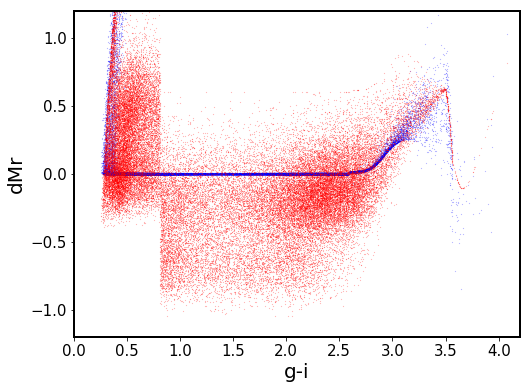

In [106]:
# Did Galfast simulation use getMainSequenceAbsMag? 
# What is the impact of unknown FeH? 
gi = sims['g'] - sims['i'] 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, dMrFit, s=0.01, c='blue')
ax.scatter(gi, dMrFitApprox, s=0.01, c='red')
ax.set_xlim(0.0,4.2)
ax.set_ylim(-1.2,1.2)
ax.set_xlabel('g-i')
ax.set_ylabel('dMr')

### Conclusions:
- the blue dots show that Galfast used the same expression as in getMainSequenceAbsMag
- the vertical plume of blue dots at the blue edge is due to giants, for which Galfast
  simulation used a different relationship; the relative counts of giants and main sequence
  stars in Galfast file should be representative of the real Galaxy 
- the red dots show the impact of unknown FeH; it looks bad for g-r<0.6 (approx. g-i<0.8)
  because bright disk stars are also included (dMr about 0.5); let's replot for 
  0.2 < g-r < 0.6 and see how faint we need to go to be dominated by halo stars 

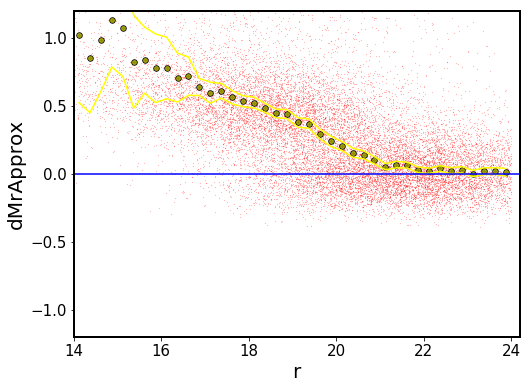

In [107]:
#  What is the impact of unknown FeH for stars with r>18 and 0.2 < g-r < 0.6
r = sims['r']
gr = sims['g'] - sims['r'] 
rB = r[(gr>0.2)&(gr<0.6)]
grB = gr[(gr>0.2)&(gr<0.6)]
dMrFitApproxB = dMrFitApprox[(gr>0.2)&(gr<0.6)]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(rB, dMrFitApproxB, s=0.01, c='red')
ax.set_xlim(14.0,24.2)
ax.set_ylim(-1.2,1.2)
ax.set_xlabel('r')
ax.set_ylabel('dMrApprox')
# binned medians to be more quantitative 
xBin, nPts, medianBin, sigGbin = fitMedians(rB, dMrFitApproxB, 14, 24, 40, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='blue')

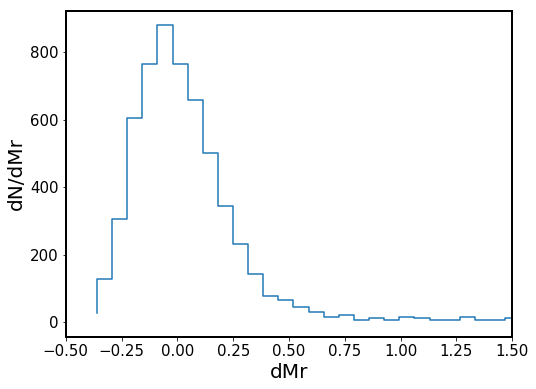

0.9188459591699004


In [108]:
xx = dMrFitApproxB[rB>21]
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(xx, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('dMr')
ax.set_ylabel('dN/dMr')
ax.set_xlim(-0.5, 1.5)
plt.show()
xxx = xx[xx<0.5]
print(np.size(xxx)/np.size(xx))

### Conclusions:
- is we select stars with 0.2 < g-r < 0.6, we have a halo-dominated 
  sample for r > 21. 
- as the histogram shows, apart from about 10% outliers (due to giant branch), 
  the majority of the sample has dMr standard deviation of about 0.2 mag, or distance errors of about 10%
- note that this estimate doesn't include photometric errors at the faint end
- let's estimate the impact of photometric errors from the slope of the Mr(g-r) relation

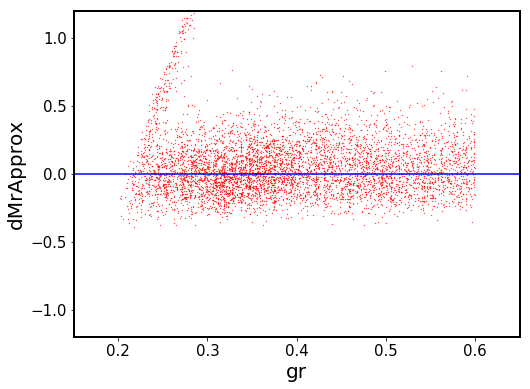

In [109]:
# plot
grBfaint = grB[rB>21]
dMrFitApproxBfaint = dMrFitApproxB[rB>21]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(grBfaint, dMrFitApproxBfaint, s=0.1, c='red')
ax.set_xlim(0.15,0.65)
ax.set_ylim(-1.2,1.2)
ax.set_xlabel('gr')
ax.set_ylabel('dMrApprox')
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='blue')

### Conclusions:
- the Mr(g-r) relation is sufficiently flat that the errors in g-r, up to about 0.3 mag 
  at the faint end (assuming 5-sigma limit), do not contribute significantly to the distance
  error
- the main contribution to the distance error comes from noise in the r band magnitude,
  which if assumed 10%, will increase the distance uncertainty from about 10% to about 15%
  at the 5-sigma limit

Thus, the main conclusion is that one should use stars with 0.2 < g-r < 0.6 and 21 < r < 24, 
and the resulting distance uncertainty will be about 10-15% for 90% of stars; for the unknown
10% of stars, distance errors will be much larger (distance will be underestimated because
we are incorrectly assuming that giants are less-luminous main sequence stars)

Let's now see what distance range we can probe, for RA-selected bins 20 deg wide: 

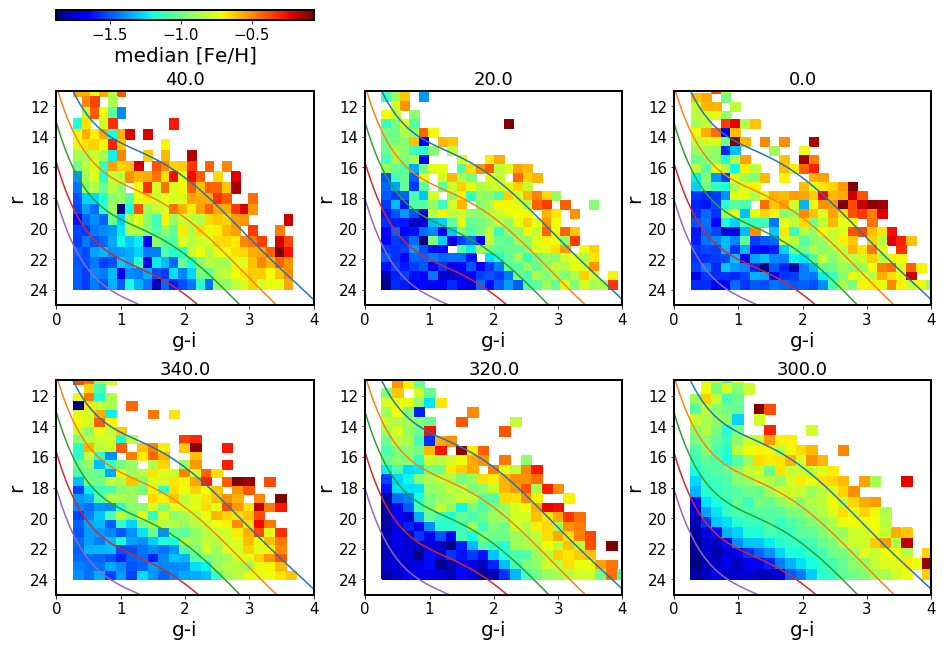

In [110]:
gi = sims['g'] - sims['i']
r = sims['r']
FeH = sims['FeH']
RA = sims['ra']
plotCoded2DmapRAbins(gi, r, FeH, RA, 0.0, 4.0, 11, 25, 25, 'g-i', 'r', '[Fe/H]')

### Conclusions:
By limiting the sample to 0.2 < g-r < 0.6 and 21 < r < 24, one can probe
the 10-30 kpc distance range. Closer than 10 kpc, distances will become
increasingly unreliable due to increasing fraction of disk stars; further
than 30 kpc, the sample incompleteness will kick in.

Let's now make a few more sanity plots:
- color-magnitude diagram
- compare r vs. RA plots for the full sample and the blue subsample, to estimate the RA range where halo definitely dominates

Text(0, 0.5, 'r')

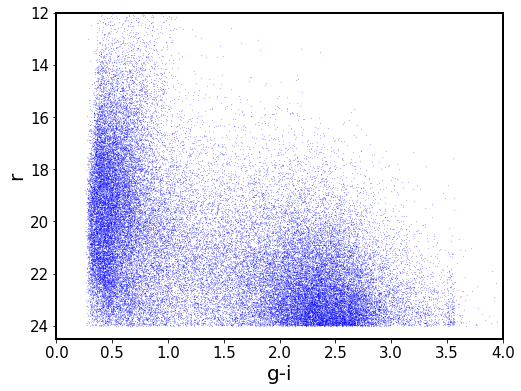

In [111]:
gi = sims['g'] - sims['i']
r = sims['r']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, r, s=0.01, c='blue') 
ax.set_xlim(-0.0,4.0)
ax.set_ylim(24.5,12)
ax.set_xlabel('g-i')
ax.set_ylabel('r')

Text(0, 0.5, 'r')

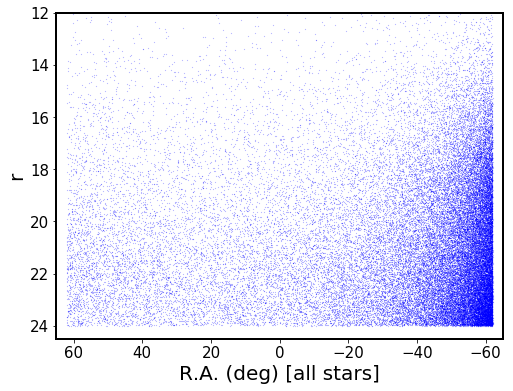

In [112]:
ra = sims['ra']  
dec = sims['dec']
# user wrapped RA to avoid disjoint regions 
raW = np.where(ra > 180, ra-360, ra)   
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, r, s=0.01, c='blue') 
ax.set_xlim(65, -65)
ax.set_ylim(24.5,12)
ax.set_xlabel('R.A. (deg) [all stars]')
ax.set_ylabel('r')

Text(0, 0.5, 'r')

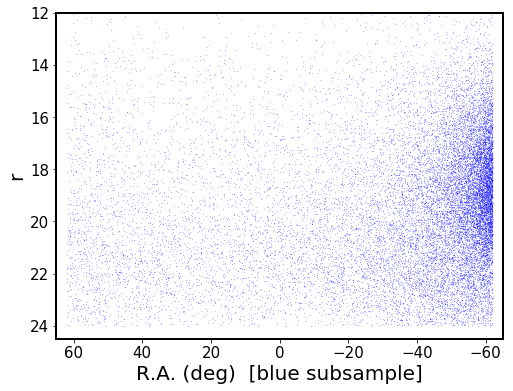

In [113]:
# and now only the blue subsample
raB = ra[(gr>0.2)&(gr<0.6)]  
decB = dec[(gr>0.2)&(gr<0.6)]  
# user wrapped RA to avoid disjoint regions 
raWB = np.where(raB > 180, raB-360, raB)   
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raWB, rB, s=0.01, c='blue') 
ax.set_xlim(65,-65)
ax.set_ylim(24.5,12)
ax.set_xlabel('R.A. (deg)  [blue subsample]')
ax.set_ylabel('r')

### Conclusions:
Therefore, if we stick to RAw > -40 deg, disk stars are safely excluded.

Note that we expect to see the Sgr tidal tail in blue stars at around RA=25 - 50 deg.
and about 20.5 < r < 21.5, e.g. see figures 24 and 25 in 
http://faculty.washington.edu/ivezic/Publications/apj_708_1_717.pdf



Text(0, 0.5, 'r-i')

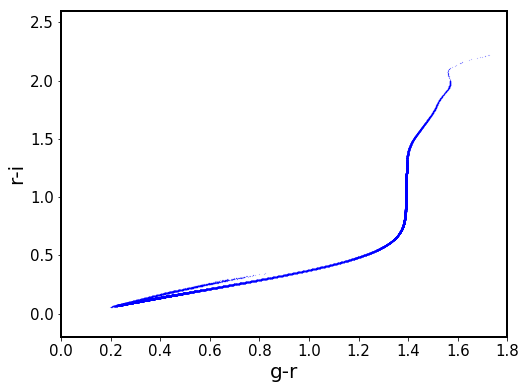

In [114]:
## note that random photometric errors are NOT included in Galfast file! 
gr = sims['g'] - sims['r']
ri = sims['r'] - sims['i']
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, ri, s=0.01, c='blue')
ax.set_xlim(0.0,1.8)
ax.set_ylim(-0.2,2.6)
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')

Text(0, 0.5, 'M_r')

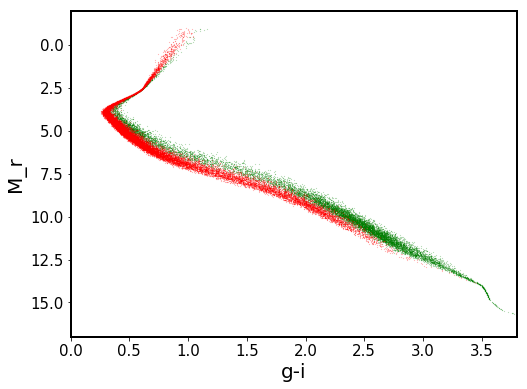

In [115]:
## pop = 0, 1, 2 corresponds to thin disk, thick disk, and halo stars, respectively
gi = sims['g'] - sims['i'] 
D = 1/sims['pi']*1000
Mr = sims['r'] - 5*np.log10(D) + 5 
# separate by pop 
gi0 = gi[sims['pop']==0]
Mr0 = Mr[sims['pop']==0]
gi1 = gi[sims['pop']==1]
Mr1 = Mr[sims['pop']==1]
gi2 = gi[sims['pop']==2]
Mr2 = Mr[sims['pop']==2]

# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi0, Mr0, s=0.01, c='green')
#ax.scatter(gi1, Mr1, s=0.01, c='blue')
ax.scatter(gi2, Mr2, s=0.01, c='red')

ax.set_xlim(0.0,3.8)
ax.set_ylim(17,-2)
ax.set_xlabel('g-i')
ax.set_ylabel('M_r')

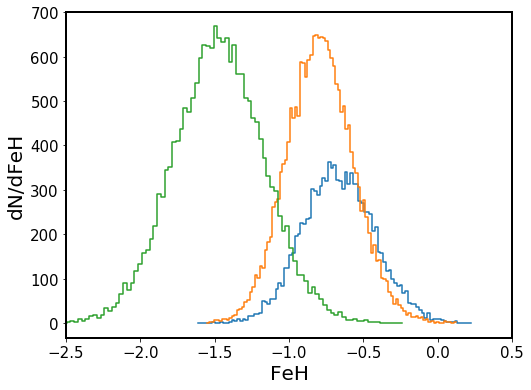

In [116]:
## the three structural components have different metallicity distributions
FeH = sims['FeH']
FeH0 = FeH[sims['pop']==0]
FeH1 = FeH[sims['pop']==1]
FeH2 = FeH[sims['pop']==2]
 
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(FeH0, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
hist, bins = np.histogram(FeH1, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
hist, bins = np.histogram(FeH2, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   


ax.set_xlabel('FeH')
ax.set_ylabel('dN/dFeH')
ax.set_xlim(-2.5, 0.5)
plt.show()

### Conclusions:
And finally let's use the simulated catalog to see what range of measured proper 
motions we should expect: 

In [117]:
## let's now look at the median proper motions in the r vs. g-i diagram
## for subsamples selected by R.A.
## note: the lines correspond to D = 0.3, 1.0, 3.0, 10 and 30 kpc 
pmRA = sims['pmra']
pmDec = sims['pmdec']
# remove very large proper motions that make plots ugly...
pmRAOK = pmRA[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
pmDecOK = pmDec[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
giOK = gi[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
rOK = r[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
RAOK = RA[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 

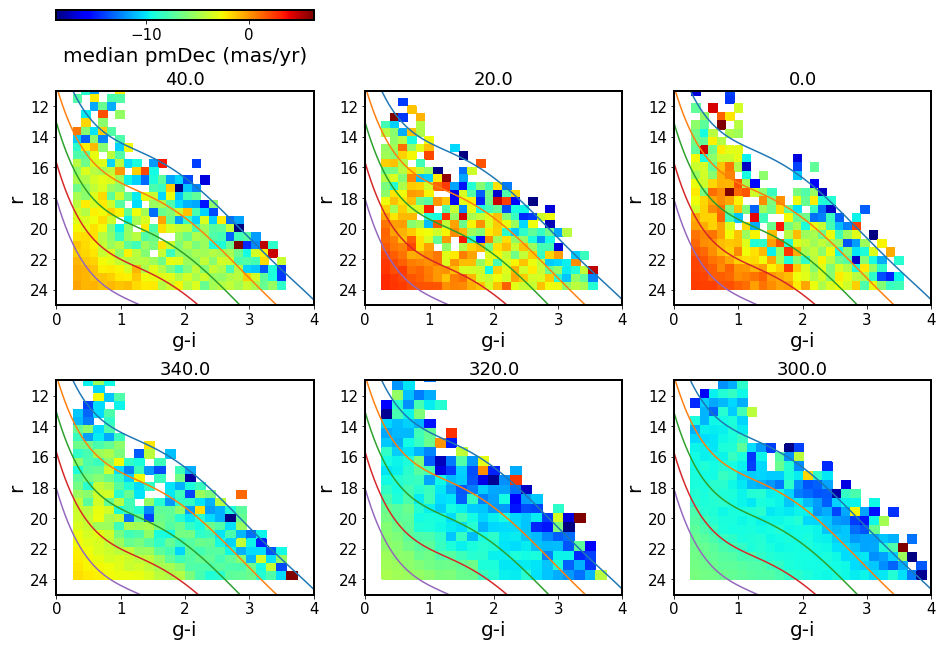

In [118]:
plotCoded2DmapRAbins(giOK, rOK, pmDecOK, RAOK, 0.0, 4.0, 11, 25, 25, 'g-i', 'r', 'pmDec (mas/yr)')

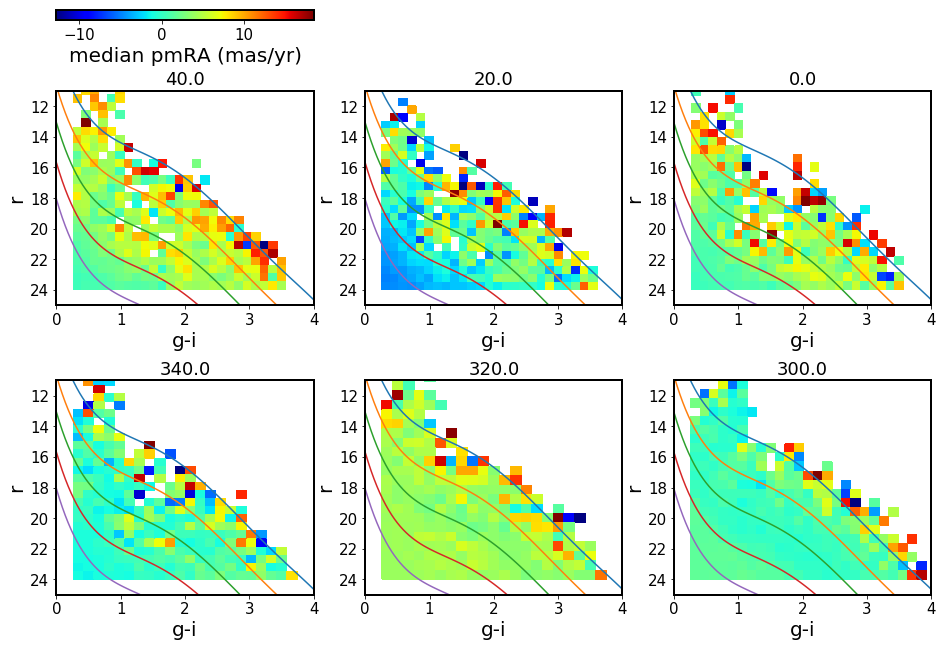

In [119]:
plotCoded2DmapRAbins(giOK, rOK, pmRAOK, RAOK, 0.0, 4.0, 11, 25, 25, 'g-i', 'r', 'pmRA (mas/yr)')

### Conclusions:

After selecting stars with 0.2 < g-r < 0.6 and distances in the range 10-30 kpc,
we should look for overdensities in the distance vs. RA plane, as well as 
coherent proper motions (that is, overdensities in the 4-dimensional D-RA-pmRA-pmDec
space)! 

Let's try that with the simulated catalog, where we don't expect any overdensities: 

In [121]:
## use the full catalog here...
sims = Table.read('stripe82_galfast_catalog.txt', format='ascii', names=colnames)
gr = sims['g']-sims['r']
gi = sims['g']-sims['i']
r = sims['r']
## true distance used by sims: 
Dkpc = 1/sims['pi']*1000
# assuming unknown FeH
FeHapprox = -1.5 + 0*Dkpc
FeHapprox[gr>0.6] = -0.6
DkpcApprox = getMainSequenceDistanceKpc(gi,FeHapprox,r)
pmRA = sims['pmra']
pmDec = sims['pmdec']
ra = sims['ra'] 
raW = np.where(ra > 180, ra-360, ra)
## now select the four main vectors for the blue subsample
cond = (gr>0.2)&(gr<0.6)&(DkpcApprox>10)&(DkpcApprox<30)
raB = ra[cond]
raWB = raW[cond]
DappB = DkpcApprox[cond]
pmRAB = pmRA[cond] 
pmDecB = pmDec[cond]
rB = r[cond] 

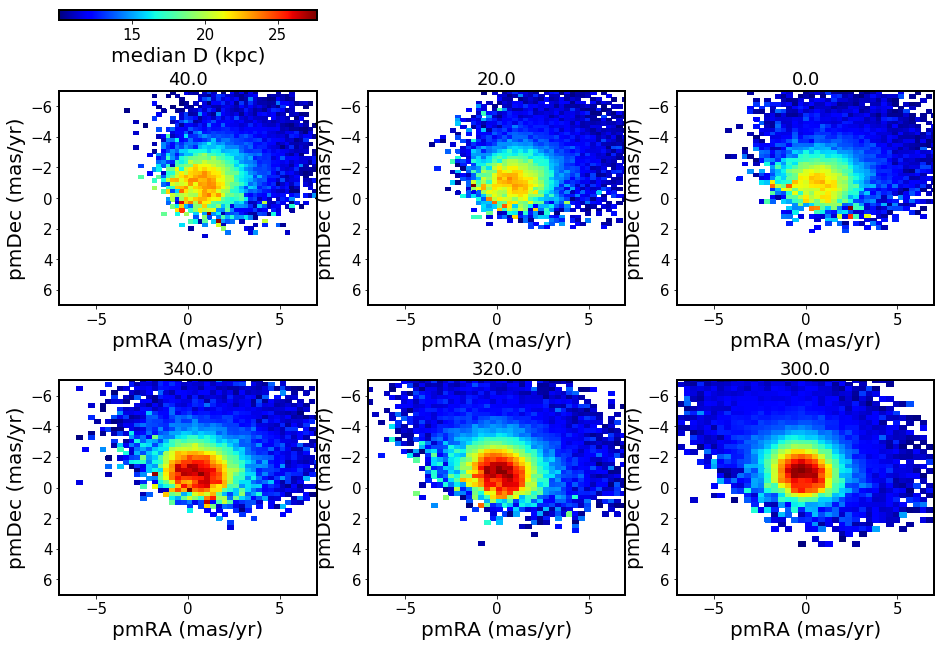

In [122]:
plotCoded2DmapRAbins(pmRAB, pmDecB, DappB, raB, -7, 7, -7, 7, 50, 'pmRA (mas/yr)', 'pmDec (mas/yr)', 'D (kpc)')

## Analysis of real data

Probably the best way to analyze data would be to select blue stars with 
0.2 < g-r < 0.6, a control sample of red stars selected by 1.2 < g-r < 1.6,
possibly a control sample of quasars (and galaxies?), and then, for 10 deg 
wide bins of RA, do the following
- plot pmRA vs. r (the median and 2-sigma envelope as above, see fitMedians) 
  for all three subsamples to test for systematics (there should be no features 
  at the same apparent magnitude for different subsamples unless there 
  are data problems)
- repeat for pmDec
- replot the blue subsample and overplot the same quantity (pmRA vs. r
  and pmDec vs. r) using the simulated dataset
- if there are "features", compare to expectations for the Sgr stream
- if all ok, replace r by distance, and proper motion by velocity, 
  and repeat the comparison between the data and simulated dataset 

And then let's talk! 